In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from pathlib import Path
import random

import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
import ndjson

import numpy as np

from scipy.stats import spearmanr

In [15]:
sns.set_style("whitegrid")

sns.set(
    font_scale=1.5,
    rc={
        "font.family": "sans-serif",
        "font.size": 16.0,
        "figure.figsize": (11.69, 8.27),
    }
)

tqdm.pandas()

## Setup

Choose a sample of 1000 DOIs from the ALS dataset (which contains full references for 5000 articles)

In [21]:
# Data directories
data_dir = Path("../data")

raw_dir = data_dir / "raw_data"
pubmed_dir = raw_dir / "pubmed"
scite_dir = raw_dir / "scite"

processed_dir = data_dir / "processed"

results_dir = data_dir / "results"

### Load datasets

In [22]:
sample_file = pubmed_dir / "1000_doi_sample.csv"

base_dois = pd.read_csv(sample_file).doi.tolist()
    
# Load ALS DOIs
als_citations = pd.read_csv(als_dir / "citations.csv")
base_citations = als_citations[als_citations.target.isin(base_dois)]
incoming_dois = base_citations.source.unique().tolist()

FileNotFoundError: [Errno 2] No such file or directory: '../data/ALS_data/citations.csv'

**Metadata**

In [7]:
base_papers_file = nb_dir / "base_papers.jsonl"

if not base_papers_file.exists():
    scite.papers(base_dois, base_papers_file)
    
with open(base_papers_file) as f:
    data = ndjson.load(f)
    
base_articles = pd.DataFrame.from_records(data)

**Citations for incoming articles (in order to calculate nr of outgoing references** 

In [8]:
citations_file = nb_dir / "incoming_citations.jsonl"

if not citations_file.exists():
    scite.citations(incoming_dois, citations_file, overwrite=True)
    
with open(citations_file) as f:
    data = ndjson.load(f)
    
incoming_citations = pd.DataFrame.from_records(data)

**Metadata for citing articles**

In [9]:
incoming_papers_file = nb_dir / "incoming_papers.jsonl"

if not incoming_papers_file.exists():
    scite.papers(incoming_dois, incoming_papers_file)

with open(incoming_papers_file) as f:
    data = ndjson.load(f)
    
incoming_articles = pd.DataFrame.from_records(data)

## Process data

In [10]:
# Merge papaer metadata
articles = pd.concat([base_articles, incoming_articles])
articles = articles.drop_duplicates(subset="doi").set_index("doi")

# merge citation data
citations = pd.concat([base_citations, incoming_citations])
citations = citations.drop_duplicates(subset="id")

In [11]:
# remove citing articles with very low out-going reference counts
temp = citations[citations.source.isin(incoming_dois)].groupby("source").target.size()
bad_dois = temp[temp<8].index

citations = citations[~citations.source.isin(bad_dois)]

# remove citations that are coming towards the incoming articles
citations = citations[~citations.target.isin(incoming_dois)]
# sns.displot(pdf[pdf<100], bins=100)
# plt.xlim(0,25)

In [12]:
def common_authors(row):
    doi_a = row["source"]
    doi_b = row["target"]
    try:
        a, b = articles.loc[[doi_a, doi_b]].authors.values
    except Exception:
        return None
    a = [str(v) for v in a]
    b = [str(v) for v in b]
    
    try:
        common_first = a[0] == b[0]
    except:
        common_first = False
    
    common_authors = len(set(a).intersection(set(b)))
    
    return common_authors, common_first

In [13]:
def create_citation_metrics(base_dois: List, citations: pd.DataFrame) -> pd.DataFrame:
    incoming_citations = citations[citations.target.isin(base_dois)]
    
    df = (
        incoming_citations[["source", "target"]]
        .groupby(["source", "target"])
        .size()
        .to_frame("mentions")
        .sort_values(by=["source", "target"]) # important to create mapping between IDs and (source, target) tuples
        .reset_index()
    )
    
    # Compute common authors
    temp = df[["source", "target"]].progress_apply(common_authors, axis=1).tolist()
    temp = pd.DataFrame(temp, columns=["common_authors", "common_first"])
    df = df.join(temp)
    
    # Metrics for citing (source) article
    sources = citations.groupby("source").target.size().to_frame("total_source_mentions")
    sources["total_source_refs"] = citations.groupby("source").target.nunique()
    sources["avg_source_refs"] = citations.groupby("source").target.value_counts().mean()
    df = df.merge(sources.reset_index(), left_on="source", right_on="source", how="left")
    
    df["mentions_per_ref"] = df["total_source_mentions"] / df["total_source_refs"]
    
    df["norm_refs"] = 1 / df["total_source_refs"]
    df["norm_mentions"] = df["mentions"] / df["total_source_mentions"]
    
    df["wf1"] =  df["norm_mentions"] * df["norm_refs"]
    df["wf2"] = np.sqrt(df["wf1"])
    
    # normalized by average mentions
#     df["wf3"] = df["mentions"] / df["avg_source_refs"] / df["total_source_refs"]

    # log transformed w1
#     df["wf3"] = np.log10(df["norm_mentions"]) + np.log10(df["norm_refs"])

    # log transformed w1
    df["wf3"] = np.log10(df["wf1"])
    
    # Filtered metrics
    df["no_first_citations"] = df[["wf1", "common_first"]].apply(
        lambda x: x["wf1"] if not x["common_first"] else 0, axis=1
    )
    df["no_collab_citations"] = df[["wf1", "common_authors"]].apply(
        lambda x: x["wf1"] if x["common_authors"] == 0 else 0, axis=1
    )

    return df

In [14]:
def calc_frac_refmen(vals: List) -> float:
    f_mentions = [v/sum(vals) for v in vals]
    f_refs = [1/len(vals) for v in vals]
    return [v1 * v2 for (v1, v2) in zip(f_mentions, f_refs)]

In [15]:
citation_metrics = create_citation_metrics(base_dois, citations)

In [16]:
(
    citation_metrics
    .corr()
    .round(2)
)

,mentions,common_authors,total_source_mentions,total_source_refs,avg_source_refs,mentions_per_ref,norm_refs,norm_mentions,wf1,wf2,wf3,no_first_citations,no_collab_citations
mentions,1.00,0.22,0.06,0.00,0.0,0.25,-0.01,0.55,0.11,0.26,0.29,0.09,0.06
common_authors,0.22,1.00,-0.08,-0.09,0.0,0.03,0.05,0.20,0.04,0.12,0.15,0.02,-0.04
total_source_mentions,0.06,-0.08,1.00,0.94,-0.0,0.17,-0.48,-0.35,-0.14,-0.45,-0.78,-0.13,-0.12
total_source_refs,0.00,-0.09,0.94,1.00,0.0,-0.08,-0.50,-0.36,-0.14,-0.47,-0.81,-0.14,-0.12
avg_source_refs,0.00,0.00,-0.00,0.00,1.0,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
mentions_per_ref,0.25,0.03,0.17,-0.08,-0.0,1.00,0.10,0.08,0.10,0.08,0.04,0.08,0.08
norm_refs,-0.01,0.05,-0.48,-0.50,0.0,0.10,1.00,0.68,0.68,0.91,0.74,0.66,0.62
norm_mentions,0.55,0.20,-0.35,-0.36,-0.0,0.08,0.68,1.00,0.67,0.91,0.72,0.62,0.53
wf1,0.11,0.04,-0.14,-0.14,-0.0,0.10,0.68,0.67,1.00,0.75,0.33,0.97,0.92
wf2,0.26,0.12,-0.45,-0.47,0.0,0.08,0.91,0.91,0.75,1.00,0.80,0.71,0.64


In [17]:
def hindex(values: List) -> int:
    values = sorted(values)
    for _ in range(1, len(values)+1):
        if _ > values[-_]:
            return _-1
    return _
        
def create_article_metrics(base_dois: List, metrics: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(index=base_dois)
    
    # Metrics for each article
    df['mentions_agg'] = metrics.groupby("target")["mentions"].sum()
    df['refs_agg'] = metrics.groupby("target")["source"].size()
    df['mentions_per_ref'] = df["mentions_agg"] / df["refs_agg"]
    
    # h-indexes
    df['mentions_hindex'] = metrics.groupby('target')['mentions'].apply(lambda x: hindex(x.tolist()))

    # Weighted refs
    df["frac_mentions_agg"] = metrics.groupby("target")["norm_mentions"].sum()
    df["frac_mentions_median"] = metrics.groupby("target")["norm_mentions"].median()
    df["frac_mentions_mean"] = metrics.groupby("target")["norm_mentions"].mean()

    df["frac_refs_agg"] = metrics.groupby("target")["norm_refs"].sum()
    df["frac_refs_median"] = metrics.groupby("target")["norm_refs"].median()
    df["frac_refs_mean"] = metrics.groupby("target")["norm_refs"].mean()

    # Mean weighted_counts
    df["wf1_mean"] = metrics.groupby("target")["wf1"].apply(lambda x: x.mean())
    df["wf1_median"] = metrics.groupby("target")["wf1"].apply(lambda x: x.median())
    df["wf1_agg"] = metrics.groupby("target")["wf1"].sum()
    
    df["wf2_mean"] = metrics.groupby("target")["wf2"].apply(lambda x: x.mean())
    df["wf2_median"] = metrics.groupby("target")["wf2"].apply(lambda x: x.median())
    df["wf2_agg"] = metrics.groupby("target")["wf2"].sum()

    df["wf3_mean"] = metrics.groupby("target")["wf3"].apply(lambda x: x.mean())
    df["wf3_median"] = metrics.groupby("target")["wf3"].apply(lambda x: x.median())
    df["wf3_agg"] = metrics.groupby("target")["wf3"].sum()

    # Collab metrics
    df["collaborations"] = metrics.groupby("target")["common_authors"].apply(lambda x: sum(x>0))
    df["agg_nocollab_citations"] = metrics.groupby("target")["no_collab_citations"].sum()
    df["median_nocollab_citations"] = metrics.groupby("target")["no_collab_citations"].apply(lambda x: x.median())

#     df["agg_nofirst_citations"] = metrics.groupby("target")["no_first_citations"].sum()
#     df["median_nofirst_citations"] = metrics.groupby("target")["no_first_citations"].apply(lambda x: x.median())

    return df

In [18]:
article_metrics = create_article_metrics(base_dois, citation_metrics)

In [29]:
fosdem_sample = articles.sample(100).index

In [34]:
articles.loc[fosdem_sample][["title", "authors", "journal", "type", "year"]].to_csv("article_metadata.csv")

In [42]:
citations[citations.target.isin(fosdem_sample)][["id", "source", "target", "snippet", "section"]].to_csv("citation_links.csv")

In [44]:
citation_metrics[citation_metrics.target.isin(fosdem_sample)][["source", "target", "mentions", "norm_mentions"]].to_csv("citation_metrics.csv")

In [51]:
article_metrics[article_metrics.index.isin(fosdem_sample)][["mentions_agg", "refs_agg"]].to_csv("article_metrics.csv")

In [19]:
(
    article_metrics[["mentions_agg", "refs_agg", "frac_refs_agg", "frac_refs_median", "frac_mentions_agg", "frac_mentions_median", "wf3_agg", "wf3_median"]]
    .corr(method="spearman")
    .round(2)
)

,mentions_agg,refs_agg,frac_refs_agg,frac_refs_median,frac_mentions_agg,frac_mentions_median,wf3_agg,wf3_median
mentions_agg,1.00,0.92,0.83,-0.19,0.91,-0.05,-0.90,-0.09
refs_agg,0.92,1.00,0.90,-0.22,0.86,-0.21,-0.99,-0.20
frac_refs_agg,0.83,0.90,1.00,0.13,0.93,0.08,-0.85,0.13
frac_refs_median,-0.19,-0.22,0.13,1.00,0.11,0.76,0.31,0.90
frac_mentions_agg,0.91,0.86,0.93,0.11,1.00,0.19,-0.80,0.19
frac_mentions_median,-0.05,-0.21,0.08,0.76,0.19,1.00,0.30,0.93
wf3_agg,-0.90,-0.99,-0.85,0.31,-0.80,0.30,1.00,0.29
wf3_median,-0.09,-0.20,0.13,0.90,0.19,0.93,0.29,1.00


In [20]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = spearmanr(df[r], df[c])[1]
    return pvalues

In [21]:
pvals = calculate_pvalues(article_metrics)
pvals.astype(float).round(3)

,mentions_agg,refs_agg,mentions_per_ref,mentions_hindex,frac_mentions_agg,frac_mentions_median,frac_mentions_mean,frac_refs_agg,frac_refs_median,frac_refs_mean,...,wf1_agg,wf2_mean,wf2_median,wf2_agg,wf3_mean,wf3_median,wf3_agg,collaborations,agg_nocollab_citations,median_nocollab_citations
mentions_agg,0.000,0.000,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.005,...,0.0,0.309,0.001,0.000,0.005,0.009,0.000,0.000,0.000,0.000
refs_agg,0.000,0.000,0.000,0.000,0.000,0.000,0.876,0.000,0.000,0.002,...,0.0,0.013,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005
mentions_per_ref,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.272,0.459,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.039
mentions_hindex,0.000,0.000,0.000,0.000,0.000,0.356,0.000,0.000,0.000,0.006,...,0.0,0.286,0.002,0.000,0.013,0.011,0.000,0.000,0.000,0.002
frac_mentions_agg,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.014
frac_mentions_median,0.115,0.000,0.000,0.356,0.000,0.000,0.000,0.012,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.000,0.000
frac_mentions_mean,0.000,0.876,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000
frac_refs_agg,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.000,0.000,0.000,...,0.0,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
frac_refs_median,0.000,0.000,0.272,0.000,0.001,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.339,0.000,0.000
frac_refs_mean,0.005,0.002,0.459,0.006,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.925,0.000,0.000


In [22]:
def create_journal_metrics(articles: pd.DataFrame, metrics: pd.DataFrame) -> pd.DataFrame:
    temp = metrics.merge(articles[["shortJournal"]], left_on="target", right_index=True, how="left")
    df = pd.DataFrame(index=articles.shortJournal.unique())
    
    df["n_articles"] = temp.groupby("shortJournal").target.nunique()
    
    df['references_agg'] = temp.groupby("shortJournal")["mentions"].sum()
    df['citations_agg'] = temp.groupby("shortJournal")["source"].nunique()
    
    df['refs_per_citation'] = df['references_agg'] / df['citations_agg']
    df["citations_per_article"] = df['references_agg'] / df["n_articles"]
    
    jour_cit_groupby = temp.groupby(["shortJournal", "target"]).source.nunique().groupby("shortJournal")
    df["citations_hindex"] = jour_cit_groupby.apply(lambda x: hindex(x.tolist()))
    df["citations_mean"] = jour_cit_groupby.mean()
    df["citations_median"] = jour_cit_groupby.median()
    
    df["wcitations_hindex"] = temp.groupby("shortJournal").weighted_citations.apply(lambda x: hindex(x.tolist()))
    df["wcitations_mean"] = temp.groupby("shortJournal").weighted_citations.mean()
    df["wcitations_median"] = temp.groupby("shortJournal").weighted_citations.median()

    return df

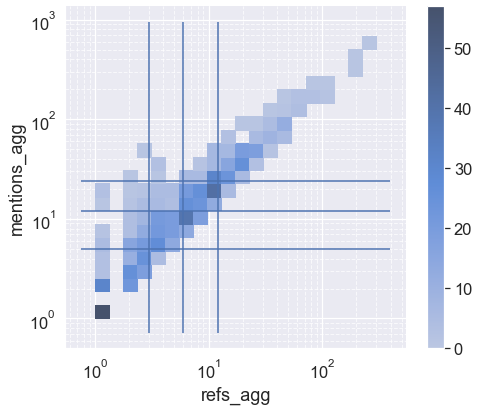

In [23]:
## Citations vs median weighted citation count
y = "mentions_agg"
x = "refs_agg"
pdf = article_metrics[article_metrics[x]!=0]
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

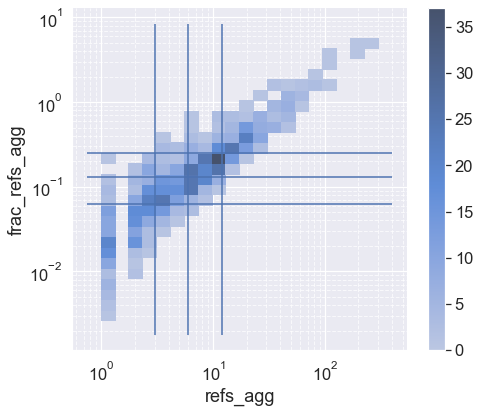

In [24]:
## Citations vs median weighted citation count
y = "frac_refs_agg"
x = "refs_agg"
pdf = article_metrics[article_metrics[x]!=0]

sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True),
            cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

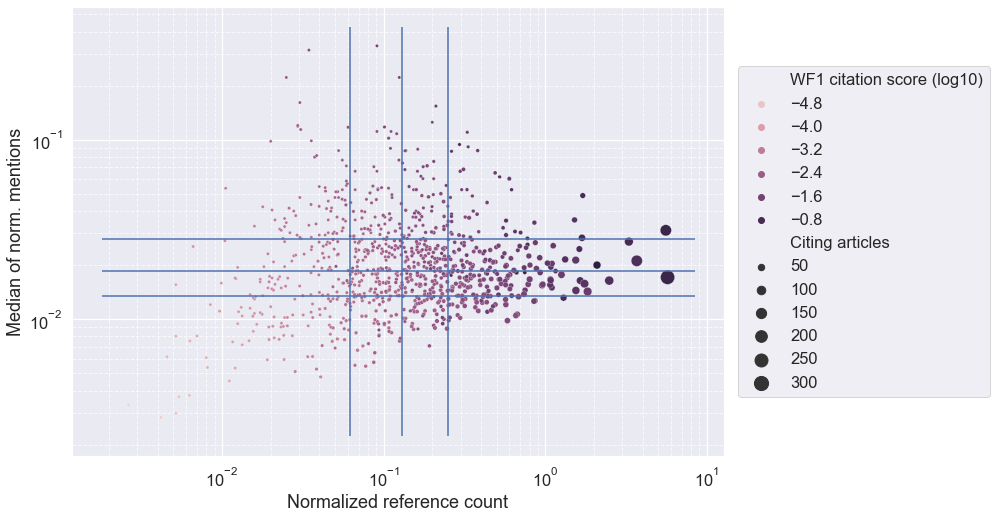

In [24]:
## Citations vs median weighted citation count
y = "frac_mentions_median"
x = "frac_refs_agg"

pdf = article_metrics[article_metrics[x]!=0]
pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = pdf.rename(columns={
    "frac_mentions_median": "Median of norm. mentions",
    "frac_refs_agg": "Normalized reference count",
    "wf1_agg_log": "WF1 citation score (log10)",
    "refs_agg": "Citing articles"
})

# Only select subset of articles
# pdf = pdf[pdf.wf1_agg_log<pdf.wf1_agg_log.median()]

sns.scatterplot(data=pdf,
                y="Median of norm. mentions",
                x="Normalized reference count",
                hue="WF1 citation score (log10)",
                size="Citing articles", sizes=(10, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

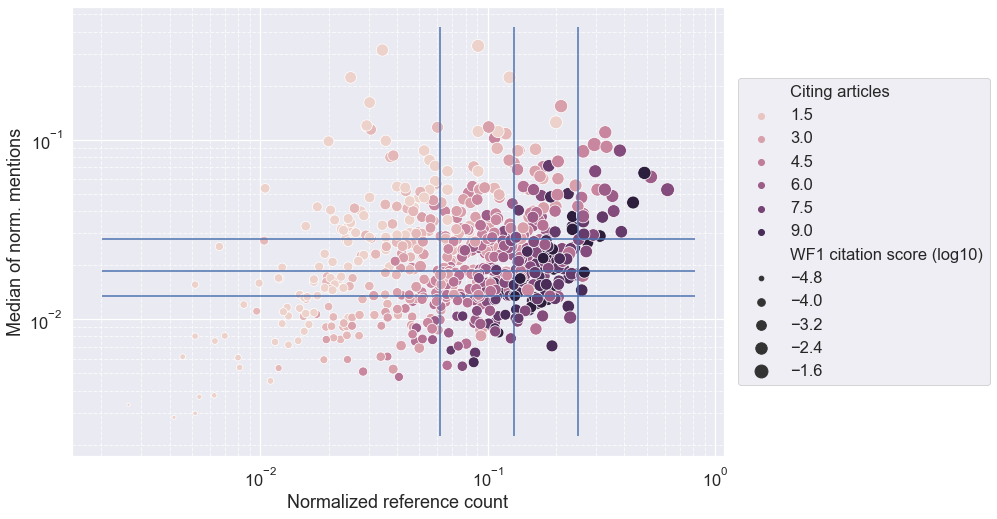

In [35]:
## Citations vs median weighted citation count
y = "frac_mentions_median"
x = "frac_refs_agg"

pdf = article_metrics[article_metrics[x]!=0]
pdf = pdf[pdf.refs_agg<=10]

pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = pdf.rename(columns={
    "frac_mentions_median": "Median of norm. mentions",
    "frac_refs_agg": "Normalized reference count",
    "wf1_agg_log": "WF1 citation score (log10)",
    "refs_agg": "Citing articles"
})

# Only select subset of articles
# pdf = pdf[pdf.wf1_agg_log<pdf.wf1_agg_log.median()]

sns.scatterplot(data=pdf,
                y="Median of norm. mentions",
                x="Normalized reference count",
                size="WF1 citation score (log10)",
                hue="Citing articles", sizes=(10, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

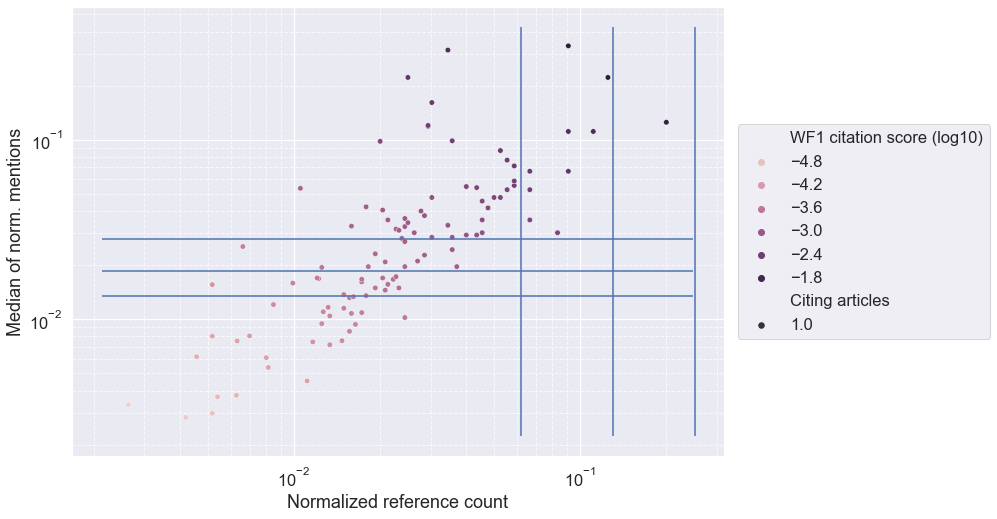

In [32]:
## Citations vs median weighted citation count
y = "frac_mentions_median"
x = "frac_refs_agg"

pdf = article_metrics[article_metrics[x]!=0]
pdf = pdf[pdf.refs_agg==1]

pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = pdf.rename(columns={
    "frac_mentions_median": "Median of norm. mentions",
    "frac_refs_agg": "Normalized reference count",
    "wf1_agg_log": "WF1 citation score (log10)",
    "refs_agg": "Citing articles"
})

# Only select subset of articles
# pdf = pdf[pdf.wf1_agg_log<pdf.wf1_agg_log.median()]

sns.scatterplot(data=pdf,
                y="Median of norm. mentions",
                x="Normalized reference count",
                hue="WF1 citation score (log10)",
                size="Citing articles", sizes=(30, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

## Explore Articles

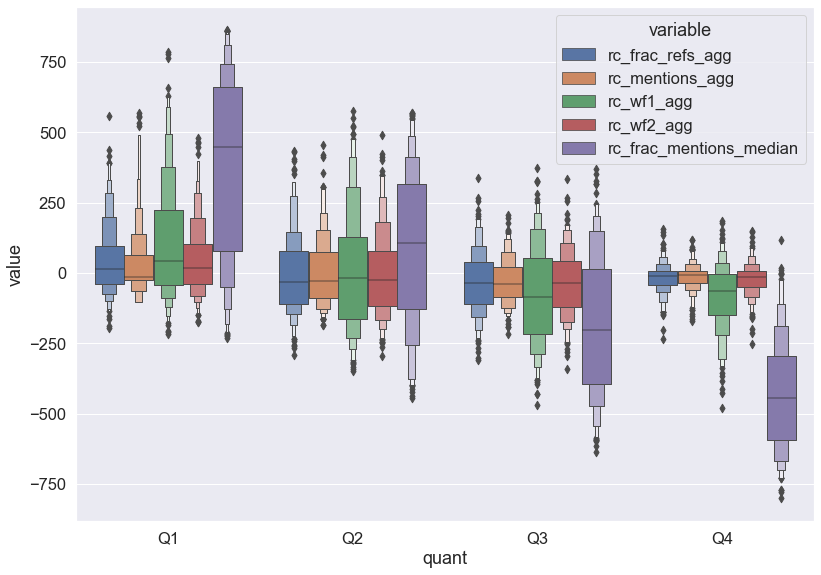

In [33]:
n_quantiles = 5
base_var = "refs_agg"
count_methods = [
    "frac_refs_agg",
    "mentions_agg",
    "wf1_agg",
    "wf2_agg",
    "frac_mentions_median",
]

df = article_metrics
df = df[[base_var] + count_methods].rank()
for cm in count_methods:
    df["rc_" + cm] = df[cm] - df[base_var]

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index"], value_vars=["rc_" + cm for cm in count_methods])

sns.boxenplot(data=pdf, hue="variable", y="value", x="quant")
plt.tight_layout()

In [ ]:
# interesting articles: 10.1083/jcb.201607048, 10.1242/dmm.028738
# both move up a lot in rankings and both are first-authored by women

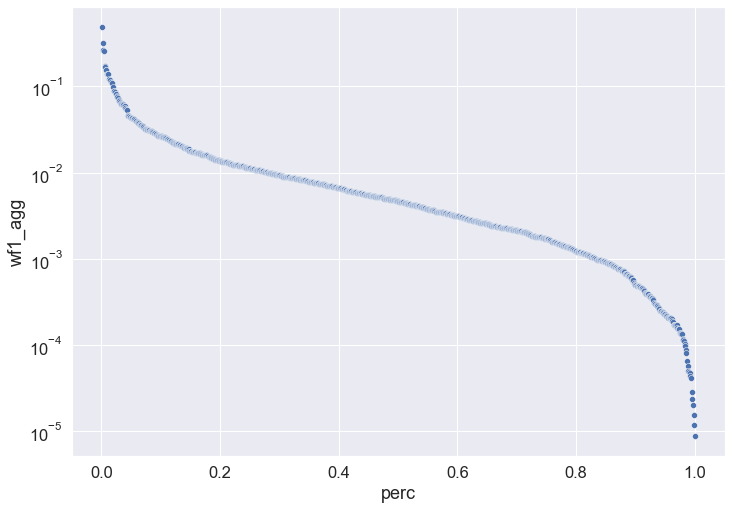

In [165]:
m = "wf1_agg"
pdf = article_metrics[[m]].copy()
pdf = pdf.sort_values(m, ascending=False)
pdf = pdf.dropna()
pdf["perc"] = [_/len(pdf) for _ in range(1,len(pdf)+1)]
sns.scatterplot(x="perc", y=m, data=pdf)
plt.yscale("log")

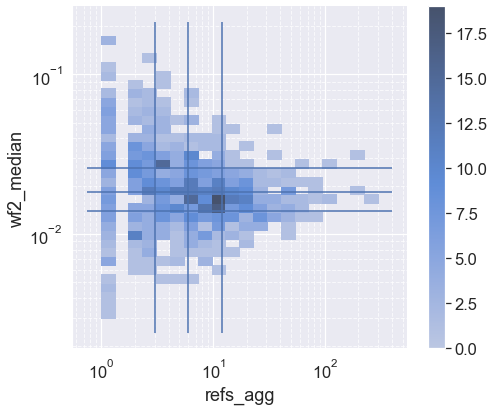

In [200]:
## Citations vs median weighted citation count
x = "refs_agg"
y = "wf2_median"
pdf = article_metrics[article_metrics[x]!=0]
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

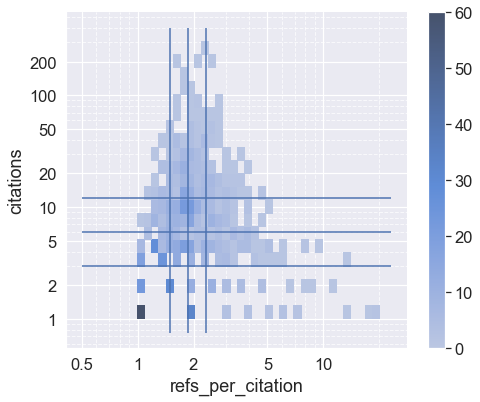

In [57]:
## Citations vs median weighted citation count
x = "refs_per_citation"
y = "citations"
pdf = article_metrics[article_metrics[x]!=0]
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

yticks = [1, 2, 5, 10, 20, 50, 100, 200]
plt.yticks(ticks=yticks, labels=yticks)
xticks = [.5, 1,2,5,10]
plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

### Investigate individual articles

In [81]:
def article_citations(df: pd.DataFrame, doi: str) -> pd.DataFrame:
    return df[df.target==doi].sort_values("weighted_citations")

def article_profile(df: pd.DataFrame, doi: str, y="wf1") -> None:
    pdf = df[df.target==doi].copy()

    pdf["collaboration"] = pdf["common_authors"] > 0

    sort_by = y
    pdf["x_order"] = pdf[sort_by].rank(method="first")
    pdf = pdf.sort_values(sort_by)

    sns.lineplot(data=pdf, x="x_order", y=y, zorder=1)
    sns.scatterplot(data=pdf, x="x_order", y=y, style="collaboration", size="mentions",
                    sizes=(20,200), legend=True, zorder=2, palette="Set2")
    plt.title(f"DOI: {doi}")
    plt.xlabel("Citing Articles")
    plt.ylabel("Weighted Citation Count");
#     plt.grid(False, axis="x")

def article_profiles(df: pd.DataFrame, dois: List, y="norm_mentions", norm_refs=False, selfcites=True,) -> None:
    fig, ax = plt.subplots(1, 1)
    for doi in tqdm(dois):
        pdf = df[df.target==doi].copy()

        pdf["collaboration"] = pdf["common_authors"] > 0

        sort_by = y
        
        if norm_refs:
            pdf["x_order"] = pdf[sort_by].rank(method="first", pct=True)
        else:
            pdf["x_order"] = pdf[sort_by].rank(method="first")

        if not selfcites:
            pdf = pdf[~pdf.collaboration]
        
        pdf = pdf.sort_values(sort_by)

        sns.lineplot(data=pdf, x="x_order", y=y, zorder=1, ax=ax)
        sns.scatterplot(data=pdf, x="x_order", y=y, style="collaboration", ax=ax,
                        sizes=(20,200), legend=False, zorder=2, palette="Set2")
    plt.title(f"{len(dois)} DOIs")
    plt.xlabel("Citing Articles")
    plt.ylabel(y);

In [303]:
pdf = article_metrics.sample(100)

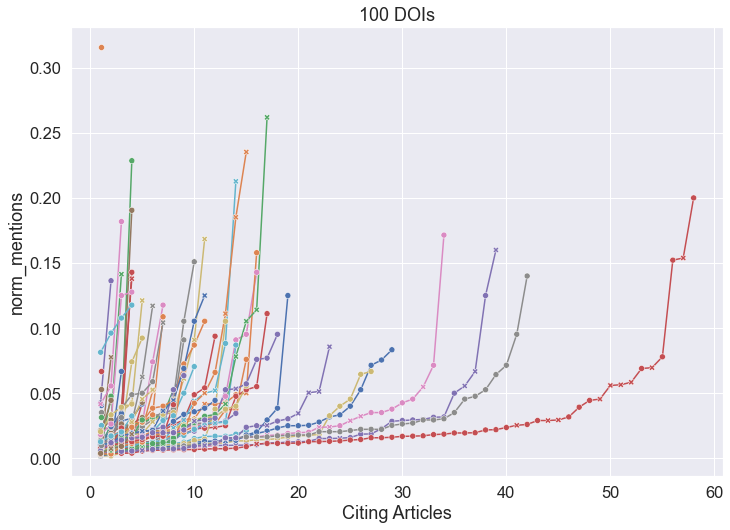

In [304]:
article_profiles(citation_metrics, pdf.index)

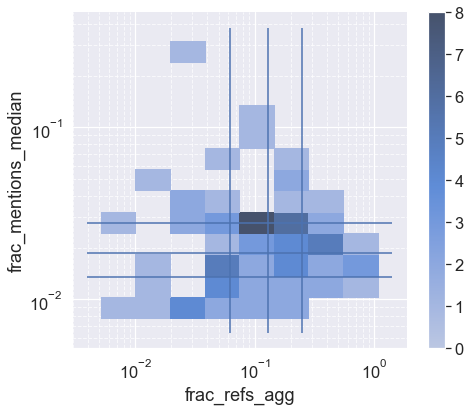

In [305]:
## Citations vs median weighted citation count
y = "frac_mentions_median"
x = "frac_refs_agg"
# pdf = article_metrics[article_metrics[x]!=0]
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True),
            cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_metrics[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_metrics[x].quantile([.25, .5, .75])], y0, y1)

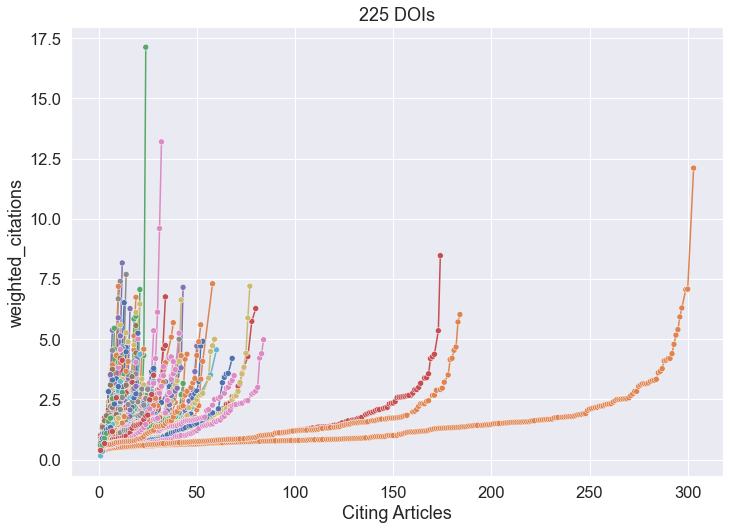

In [329]:
top_articles = article_metrics[
    (article_metrics.citations>article_metrics.citations.median()) &
    (article_metrics.median_weighted_citations>article_metrics.median_weighted_citations.median())]
article_profiles(top_articles.index.tolist(), selfcites=False)
# plt.loglog()

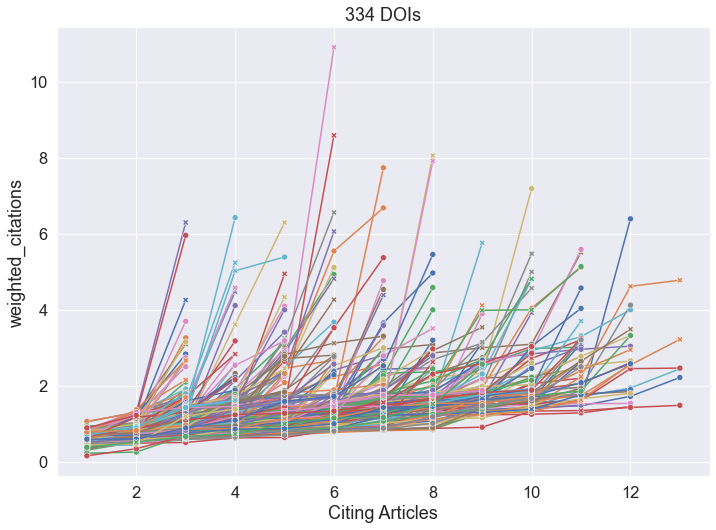

In [330]:
pdf = article_metrics[
    (article_metrics.citations.quantile(.2) < article_metrics.citations) &
    (article_metrics.citations < article_metrics.citations.quantile(.8)) & 
    (article_metrics.median_weighted_citations.quantile(.2) < article_metrics.median_weighted_citations) &
    (article_metrics.median_weighted_citations < article_metrics.median_weighted_citations.quantile(.8))
]

article_profiles(pdf.index.tolist())

(0.0, 110.0)

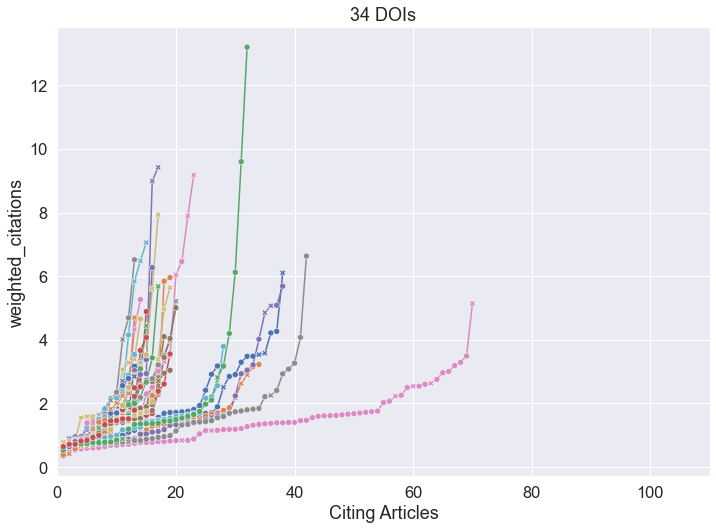

In [332]:
top_articles = article_metrics[
    (article_metrics.citations>article_metrics.citations.quantile(.75)) &
    (article_metrics.median_weighted_citations>article_metrics.median_weighted_citations.quantile(.75))]
article_profiles(top_articles.index.tolist())
plt.xlim((0,110))

### Gender

In [320]:
authors = (
    articles.loc[base_dois]["authors"]
    .explode()
    .to_frame("author_dict")
    .dropna()
    .reset_index()
)
authors = authors.join(pd.DataFrame(authors.author_dict.tolist()))
authors.given = authors.given.map(lambda x: x.split(" ")[0] if pd.notna(x) else x)
authors.to_csv(nb_dir / "names.csv")

In [320]:
df = pd.read_csv(nb_dir / "genders.csv", index_col=0)

In [321]:
def get_first_author_gender(row):
    try:
        name = row.authors[0]["given"]
        name = name.split(" ")[0]
        g = df[df.name == name].gender.iloc[0]
        return g
    except:
        return None

In [322]:
articles["first_author_gender"] = articles.progress_apply(get_first_author_gender, axis=1)
article_metrics = article_metrics.join(articles.first_author_gender)

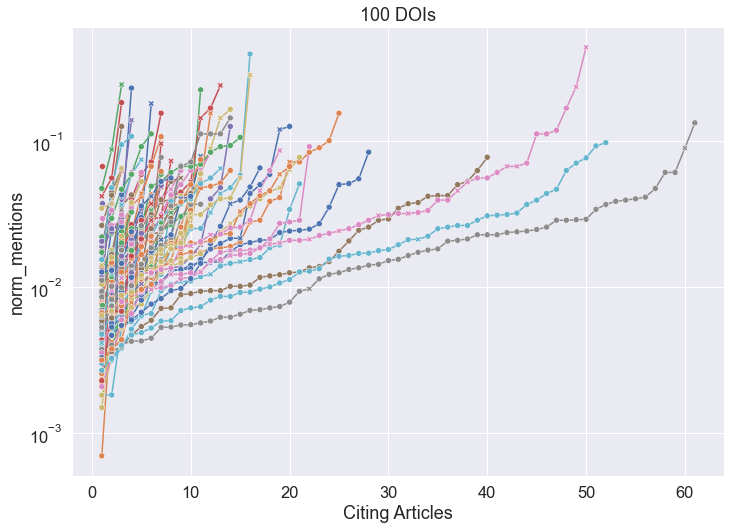

In [324]:
pdf = article_metrics[article_metrics.first_author_gender=="male"].sample(100)
article_profiles(citation_metrics, pdf.index)
plt.yscale("log")

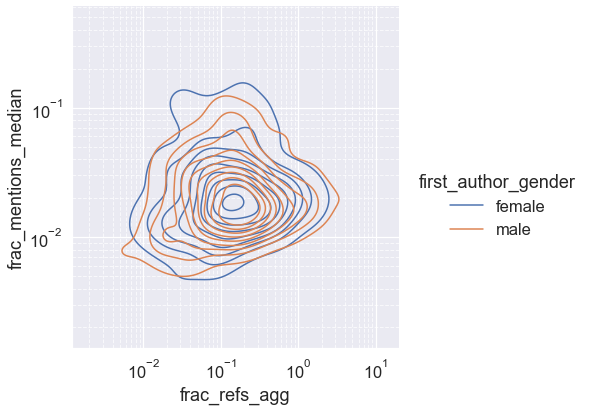

In [328]:
sns.displot(data=article_metrics, y="frac_mentions_median", x="frac_refs_agg", hue="first_author_gender", kind="kde",
            log_scale=(True, True), cbar=False, height=6)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# xticks = [.5, 1,2,5,10]
# plt.xticks(ticks=xticks, labels=xticks);

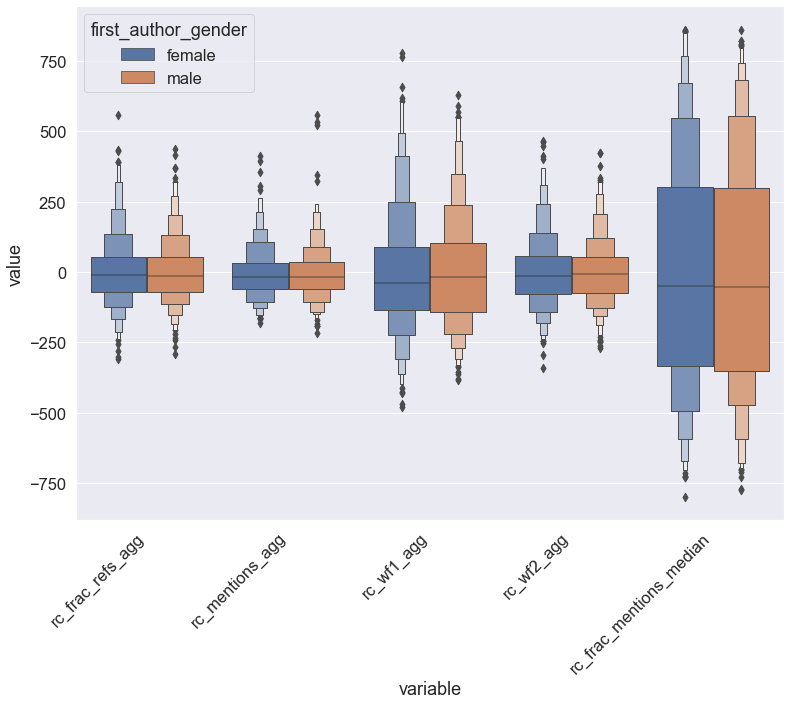

In [331]:
base_var = "refs_agg"
count_methods = [
    "frac_refs_agg",
    "mentions_agg",
    "wf1_agg",
    "wf2_agg",
    "frac_mentions_median",
]
n_quantiles = 4

df = article_metrics
df = df[[base_var] + count_methods].rank()
for cm in count_methods:
    df["rc_" + cm] = df[cm] - df[base_var]
df = df.join(articles.first_author_gender)

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index", "first_author_gender"], value_vars=["rc_" + cm for cm in count_methods])

sns.boxenplot(data=pdf, x="variable", y="value", hue="first_author_gender")
plt.tight_layout()
plt.xticks(rotation=45, ha="right");

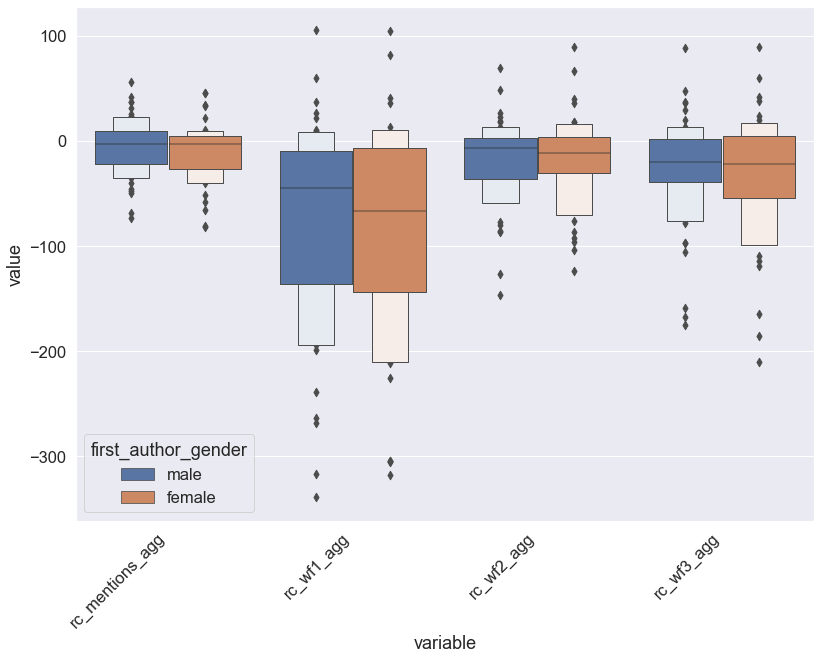

In [224]:
base_var = "refs_agg"
count_methods = [
    "mentions_agg",
    "wf1_agg",
    "wf2_agg",
    "wf3_agg",
]
n_quantiles = 8

df = article_metrics
df = df[[base_var] + count_methods].rank()
for cm in count_methods:
    df["rc_" + cm] = df[cm] - df[base_var]
df = df.join(articles.first_author_gender)

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index", "first_author_gender"], value_vars=["rc_" + cm for cm in count_methods])

sns.boxenplot(data=pdf[pdf.quant=="Q7"], x="variable", y="value", hue="first_author_gender")
plt.tight_layout()
plt.xticks(rotation=45, ha="right");